In [1]:
import numpy as np
import qutip as qt
from matplotlib import pyplot as plt
from scipy.special import hermite
from scipy.integrate import quad

In [2]:
m = 1.0  # Mass of the particle
hbar = 1.0  # Planck's constant in natural units
x_0 = 1.
omega = hbar / (2 * m * x_0**2)
Nmax = 200  # Maximum Fock state to consider


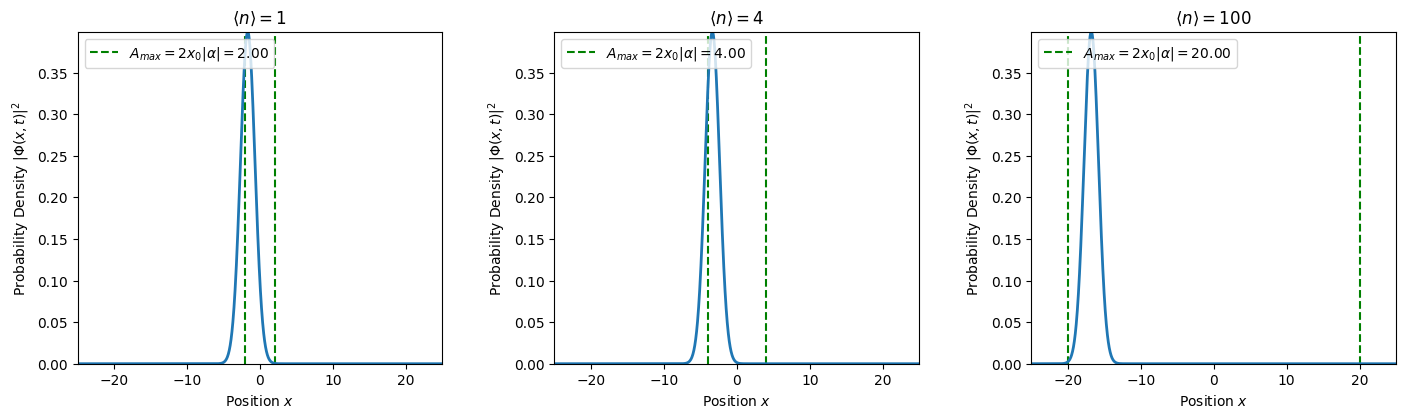

In [3]:
from scipy.special import factorial
from matplotlib.animation import FuncAnimation, PillowWriter

##define psi_n by recurrence and this time return all elements
def psi_n_whole(x, n, x_0=1.0):
    psin = []
    
    # Initialize psi_{0} and psi_{1}
    psi_0 = (np.exp(-x**2 / (4 * x_0**2))/ (2 * np.pi * x_0**2)**0.25)  # Psi_0(x)
    psi_1 = x * psi_0 / x_0  # Psi_1(x)
    psin.append(psi_0)
    psin.append(psi_1)
    # Calculate psi_n(x) for 1 <= n <= desired n using recurrence relation
    for i in range(1, n):
        psi_next = (x * psin[i] / x_0  - np.sqrt(i) * psin[i-1]) / np.sqrt(i+1)
        psin.append(psi_next)
    
    # Return complete psi_n
    return psin

Nmax = 200  # Maximum Fock state to consider
x_0 = 1.0   # Valeur par défaut de x_0
x_vals = np.linspace(-25 * x_0, 25 * x_0, 2000)  # Position space range
time_steps = 600  # Number of time steps for the animation
total_time = 20.0  # Total time for the animation
dt = total_time / time_steps  # Time step duration

# Définir les fonctions
def phi_n_coherent(alpha, Nmax):
    norm = np.exp(-(np.abs(alpha)**2) / 2)
    coeffs = [(alpha**n) / np.sqrt(factorial(n)) for n in range(Nmax + 1)]
    coeffs = np.array(coeffs) * norm
    return coeffs

# Pré-calculer psi_n (supposons que psi_n_whole est déjà défini)
psi_n_values = np.array(psi_n_whole(x_vals, Nmax, x_0=x_0))

# Coefficients de l'état cohérent
alpha_values = [1, 2, 10]                      ##-------------------## Changer les valeurs de alpha ici ##-------------------#
alpha_strs = ["$\\alpha = 1$", "$\\alpha = 2$", "$\\alpha = 10$"]

phi_n_coeffs_arr_coherent = np.array([phi_n_coherent(a, Nmax=Nmax) for a in alpha_values])

# Tableau temporel
exponentials = np.exp(
    -1j * omega * np.outer(np.arange(Nmax + 1), np.linspace(0, total_time, time_steps))
)

# Pré-calculer l'évolution temporelle de l'onde Φ(x, t)
phi_x_t_coherent = np.array(
    [
        (
            psi_n_values[:, :, np.newaxis]
            * exponentials[:, np.newaxis, :]
            * phi_n_coeffs[:, np.newaxis, np.newaxis]
        ).sum(axis=0)
        for phi_n_coeffs in phi_n_coeffs_arr_coherent
    ]
)

# Créer et sauvegarder les animations pour chaque valeur de alpha
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 ligne, 3 colonnes
axes = axes.flatten()

plt.tight_layout(pad=5.0)

# Ajuster les limites et les labels pour chaque subplot
for i, ax in enumerate(axes):
    ax.set_xlim(x_vals[0], x_vals[-1])
    ax.set_ylim(0, np.max(np.abs(phi_x_t_coherent[i]) ** 2))
    ax.set_ylabel("Probability Density $|\Phi(x, t)|^2$")
    ax.set_xlabel("Position $x$")
    ax.set_title(r'$\langle n \rangle = $' + str(np.abs(alpha_values[i])**2))
    # Ajout de la ligne verticale correspondant à A_max = 2*x_0*|alpha|
    A_max = 2 * x_0 * np.abs(alpha_values[i])
    ax.axvline(x=A_max, color='green', linestyle='--', label=f'$A_{{max}} = 2x_0|\\alpha| = {A_max:.2f}$')
    ax.axvline(x=-A_max, color='green', linestyle='--')
    ax.legend(loc='upper left')

# Créer les lignes de graphique
line = [axes[i].plot([], [], lw=2)[0] for i in range(3)]

# Fonction d'animation
def animate(i):
    for idx in range(3):
        line[idx].set_data(x_vals, np.abs(phi_x_t_coherent[idx, :, i]) ** 2)
    return line

# Créer l'animation
ani = FuncAnimation(fig, animate, frames=time_steps, interval=50, blit=True)

# Sauvegarder comme MP4
ani.save("wavepacket_evolution_coherent_state.mp4", writer="ffmpeg", fps=30)

plt.show()


### Preuve pour la moyenne :

$\ket{\alpha(t)} = \sum_{n=0}^{\infty} \frac{\alpha(t)^n}{\sqrt{n!}} \ket{n}$  avec $\alpha(t)=\alpha e^{-i\omega t}$ ; $\hat{a}_- \ket{\alpha(t)} = \alpha(t) \ket{\alpha(t)}$ ; $\bra{\alpha(t)} \hat{a}_+ = \bra{\alpha(t)} \alpha^*(t)$

$\bra{\alpha(t)} \hat{X} \ket{\alpha(t)} = \bra{\alpha(t)} x_0 ({\hat{a}}_- + {\hat{a}}_+) \ket{\alpha(t)} = x_0 ( \bra{\alpha(t)} \alpha(t) \ket{\alpha(t)} + \bra{\alpha(t)} \alpha(t)^* \ket{\alpha(t)})$


on obtient : $\bra{\alpha(t)} \hat{X} \ket{\alpha(t)} = x_0 (\alpha(t) + \alpha^*(t))$


Avec $ \alpha(t) = \alpha e^{-i\omega t} $, nous avons :


$\alpha^*(t) = (\alpha e^{-i\omega t})^* = \alpha^* e^{i\omega t}$

Donc : $\bra{\alpha(t)} \hat{X} \ket{\alpha(t)} = x_0 \left(\alpha e^{-i\omega t} + \alpha^* e^{i\omega t}\right)$


Or, cette expression est simplement : $\bra{\alpha(t)} \hat{X} \ket{\alpha(t)} = x_0 \cdot 2 \Re (\alpha e^{-i\omega t})$

Finalement : 
$\bra{\alpha(t)} \hat{X} \ket{\alpha(t)} = 2 x_0 |\alpha| \cos(\omega t + \theta)$

Ce qui nous permet de dire que l'amplitude maximale est donnée par : $A_{max} = 2x_0\vert\alpha\vert = 2x_0 \sqrt{\langle n \rangle}$


